In [1]:
from pathlib import Path
import numpy as np
import os, shutil
import matplotlib.pyplot as plt

from PIL import Image

from tqdm.auto import tqdm

import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchsummary import summary
from torch.utils.data.dataset import Subset
from torch import nn

In [2]:
good_data_path = "Detection/Carpet/carpet/train"
trans = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])
good_data = ImageFolder(root = good_data_path, transform = trans)

# data split

tr_ds, ts_ds = torch.utils.data.random_split(good_data, [0.8, 0.2])
print(len(tr_ds))
print(len(ts_ds))


# Dataloader

tr_dl = DataLoader(tr_ds, batch_size = 16, shuffle = True)
ts_dl = DataLoader(ts_ds, batch_size = 16, shuffle = True)

print(len(tr_dl))
print(len(ts_dl))

224
56
14
4


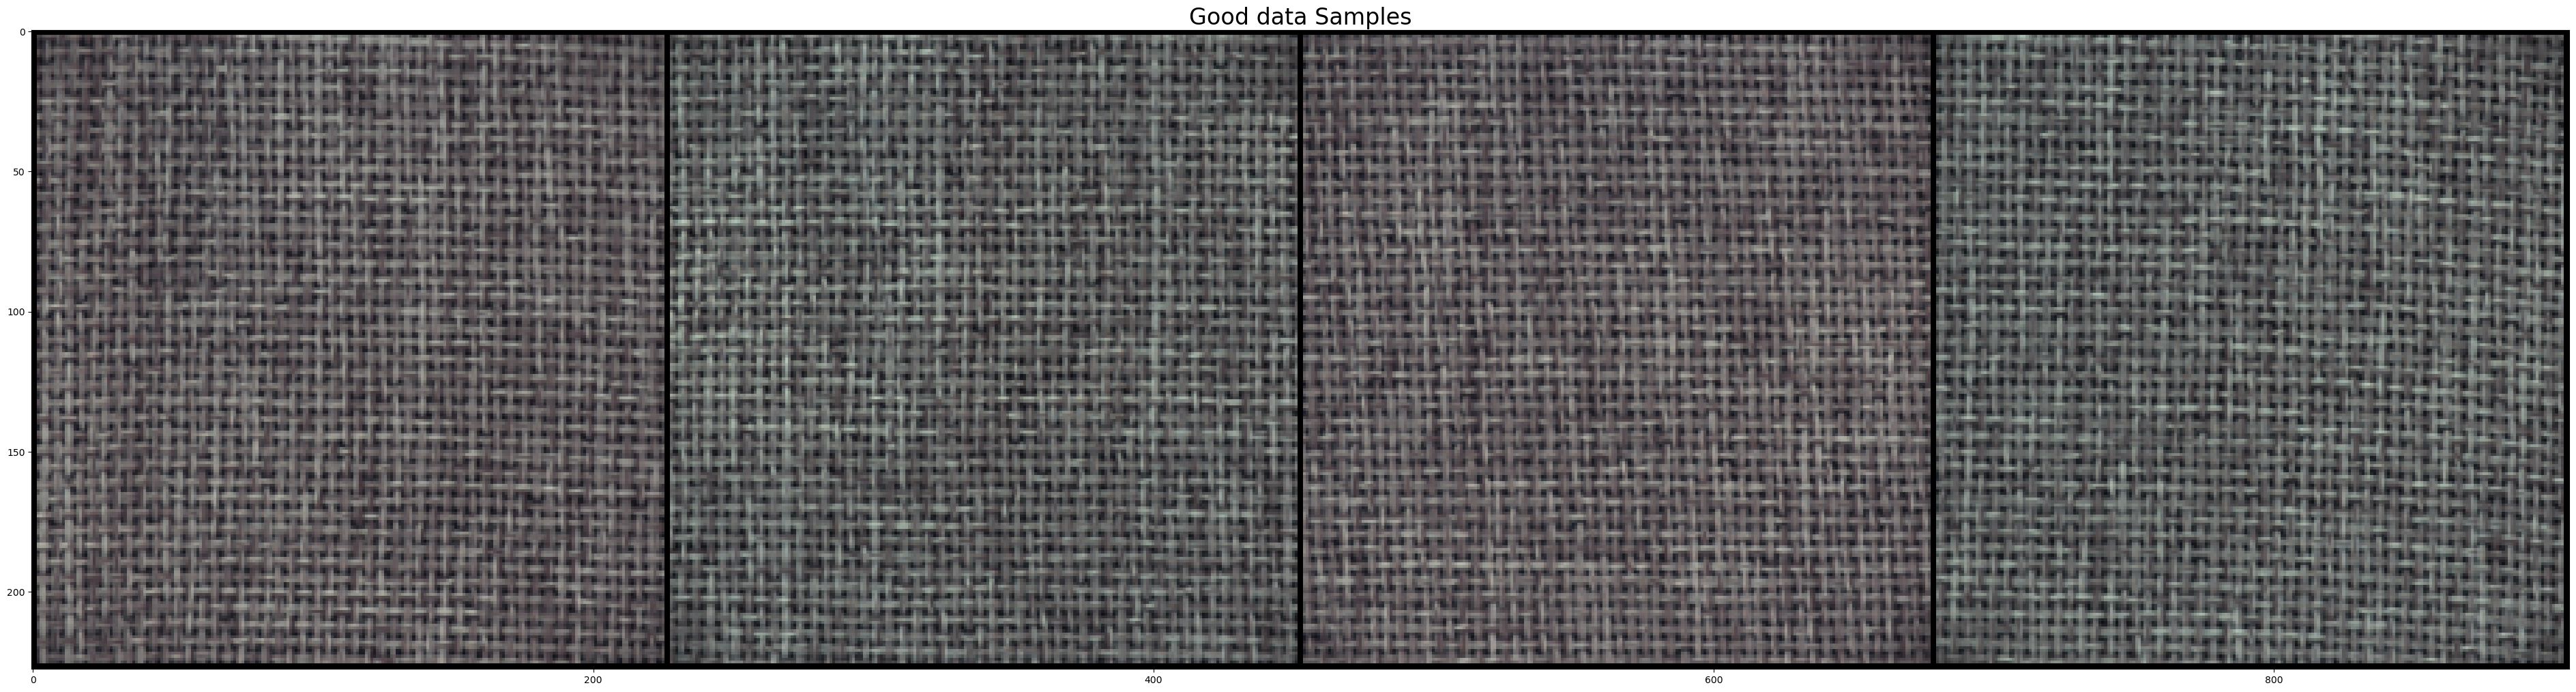

In [3]:
im_batch, lbel = next(iter(tr_dl))

plt.figure(figsize=(12*4, 48*4))
grid = torchvision.utils.make_grid(im_batch[0:4], padding =2, nrow = 4)
plt.imshow(grid.permute(1,2,0))
plt.title("Good data Samples", fontsize=24)
plt.show()

In [4]:
# Autoencoder Model

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2, stride=2),

            nn.Conv2d(128, 256, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2, stride=2),
            

            nn.Conv2d(256, 256, kernel_size=4),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size = 2, stride=2),
            
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size = 4, stride =2, output_padding=1),
            nn.ReLU(),
            

            nn.ConvTranspose2d(256, 128, kernel_size = 5, stride =2, output_padding=1),
            nn.ReLU(),
            

            nn.ConvTranspose2d(128, 3, kernel_size = 5, stride =2, output_padding=1),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [5]:
model = Autoencoder()
device = "cuda:1" if torch.cuda.is_available() else "cpu"
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(256, 256, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(4, 4), stride=(2, 2), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(256, 128, kernel_size=(5, 5), stride=(2, 2), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(128, 3, kernel_size=(5, 5), stride=(2, 2), output_padding=(1, 1))
    (5): ReLU()
  )
)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch : 1
Training  loss : 0.113
Validation  loss : 0.109
Epoch : 6
Training  loss : 0.038
Validation  loss : 0.038
Epoch : 11
Training  loss : 0.022
Validation  loss : 0.021
Epoch : 16
Training  loss : 0.013
Validation  loss : 0.013
Epoch : 21
Training  loss : 0.013
Validation  loss : 0.013
Epoch : 26
Training  loss : 0.012
Validation  loss : 0.012
Epoch : 31
Training  loss : 0.009
Validation  loss : 0.009
Epoch : 36
Training  loss : 0.009
Validation  loss : 0.009
Epoch : 41
Training  loss : 0.008
Validation  loss : 0.008
Epoch : 46
Training  loss : 0.008
Validation  loss : 0.007
Epoch : 51
Training  loss : 0.006
Validation  loss : 0.006
Epoch : 56
Training  loss : 0.006
Validation  loss : 0.006
Epoch : 61
Training  loss : 0.006
Validation  loss : 0.006
Epoch : 66
Training  loss : 0.006
Validation  loss : 0.006
Epoch : 71
Training  loss : 0.005
Validation  loss : 0.005
Epoch : 76
Training  loss : 0.005
Validation  loss : 0.005
Epoch : 81
Training  loss : 0.005
Validation  loss : 0.005

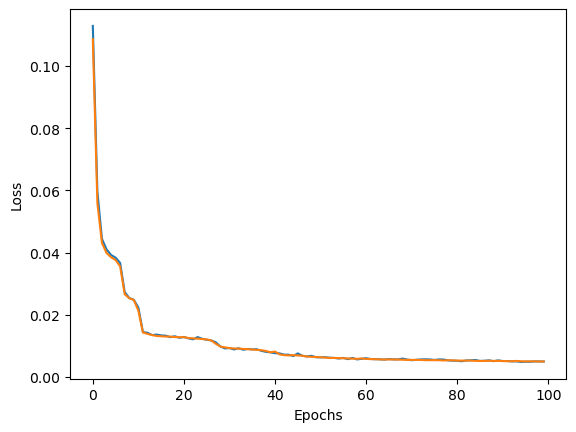

In [6]:
loss_acc = []
loss_val= []

epochs = 100
for epoch in tqdm(range(epochs)):
    model.train()
    for im, _ in (tr_dl):
        im = im.to(device)
        pred = model(im)
        loss = loss_fn(pred, im)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_acc.append(loss.item())
    
    # Validation

    model.eval()
    with torch.no_grad():
        val_loss_sum = 0
        number_batch = 0
        for img, _ in (ts_dl):
            img = img.to(device)
            pred = model(img)
            val_loss = loss_fn(pred, img)
            val_loss_sum +=val_loss.item()
            number_batch +=1
        val_avg_loss = val_loss_sum/number_batch
        loss_val.append(val_avg_loss)

        if epoch % 5 == 0:
            print(f"Epoch : {epoch+1}")
            print(f"Training  loss :{loss.item(): .3f}")
            print(f"Validation  loss :{val_avg_loss: .3f}")
plt.plot(loss_acc, label  = "Training Loss")
plt.plot(loss_val, label = "Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()
            
        

In [7]:
# save model
os.makedirs("model_file", exist_ok= True)
torch.save(model.state_dict(), "model_file/simple_autoencode_L2_loss.pth")

In [6]:
chekpoints = torch.load("model_file/simple_autoencode_L2_loss.pth", weights_only=True)
model.load_state_dict(chekpoints)

<All keys matched successfully>

torch.Size([16, 224, 224])


<Figure size 1600x1200 with 0 Axes>

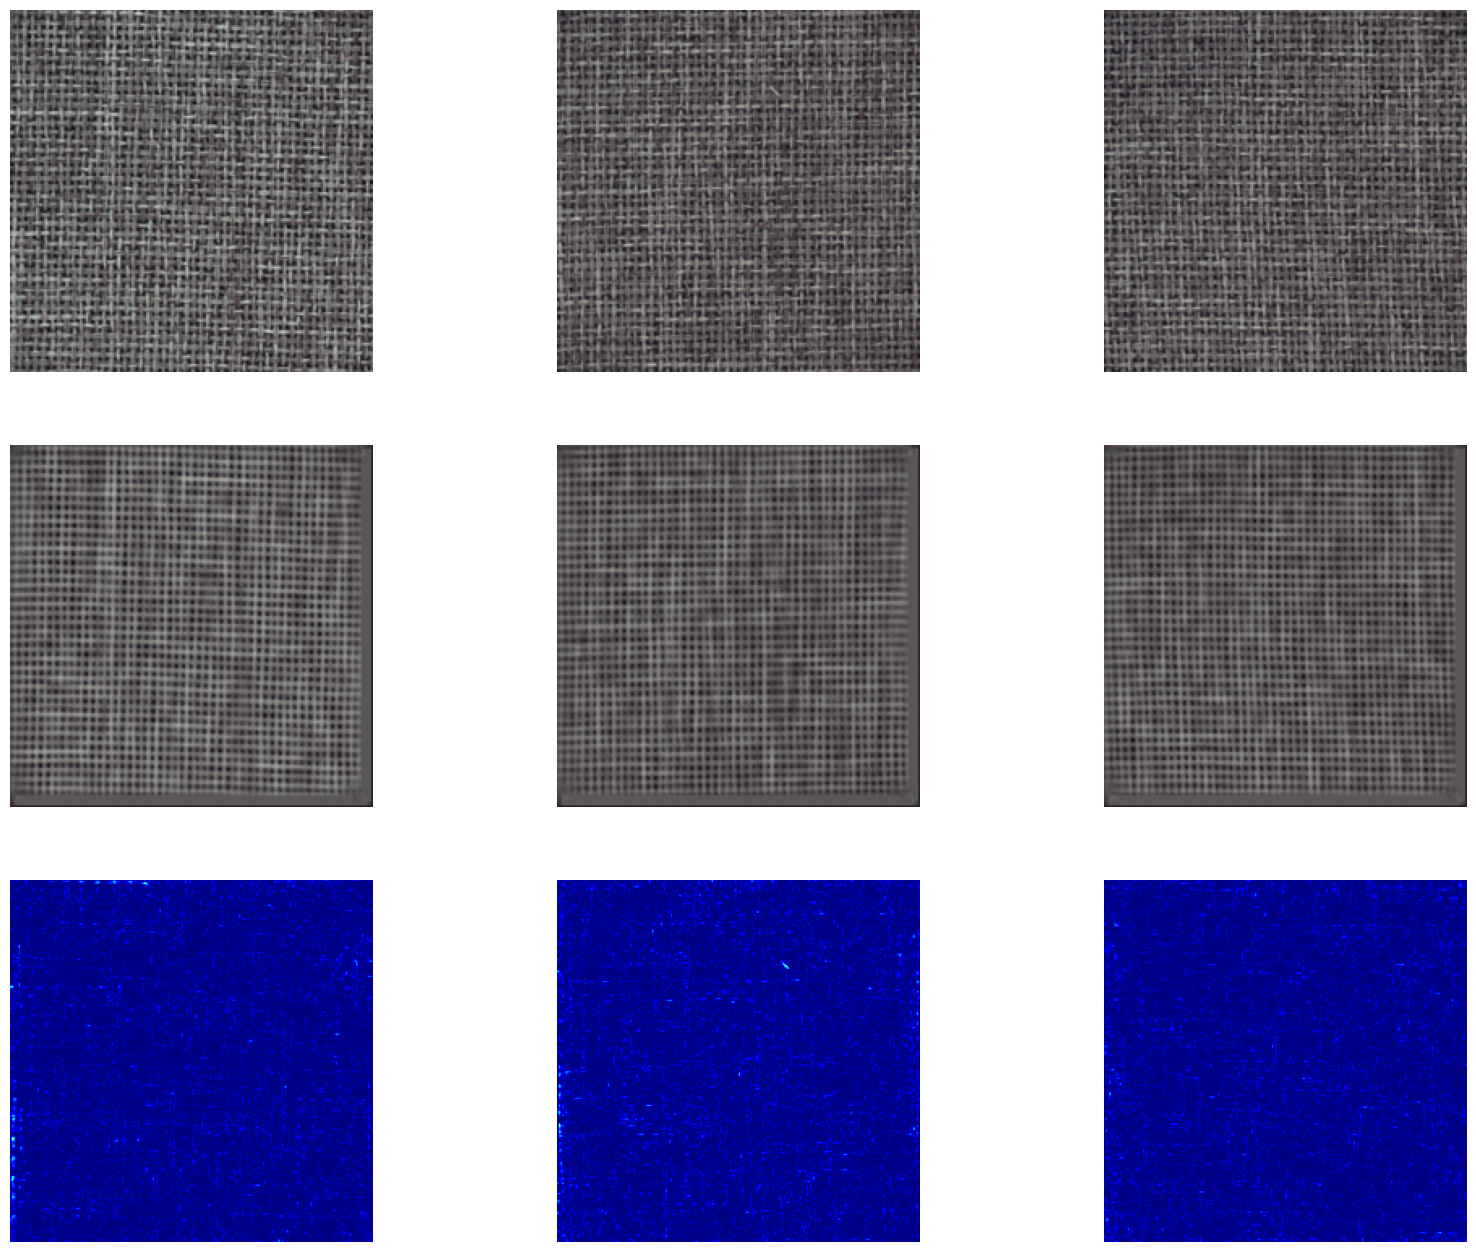

In [7]:
with torch.no_grad():
    for data, _ in tr_dl:
        data = data.to(device)
        recon = model(data)
        break

recon_error =  ((data-recon)**2).mean(axis=1)
print(recon_error.shape)

plt.figure(dpi=250)
fig, ax = plt.subplots(3, 3, figsize=(5*4, 4*4))
for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1, 2, 0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1, 2, 0)))
    ax[2, i].imshow(recon_error[i][0:-10,0:-10].cpu().numpy(), cmap='jet',vmax= torch.max(recon_error[i])) #[0:-10,0:-10]
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')
plt.show()

<Figure size 1600x1200 with 0 Axes>

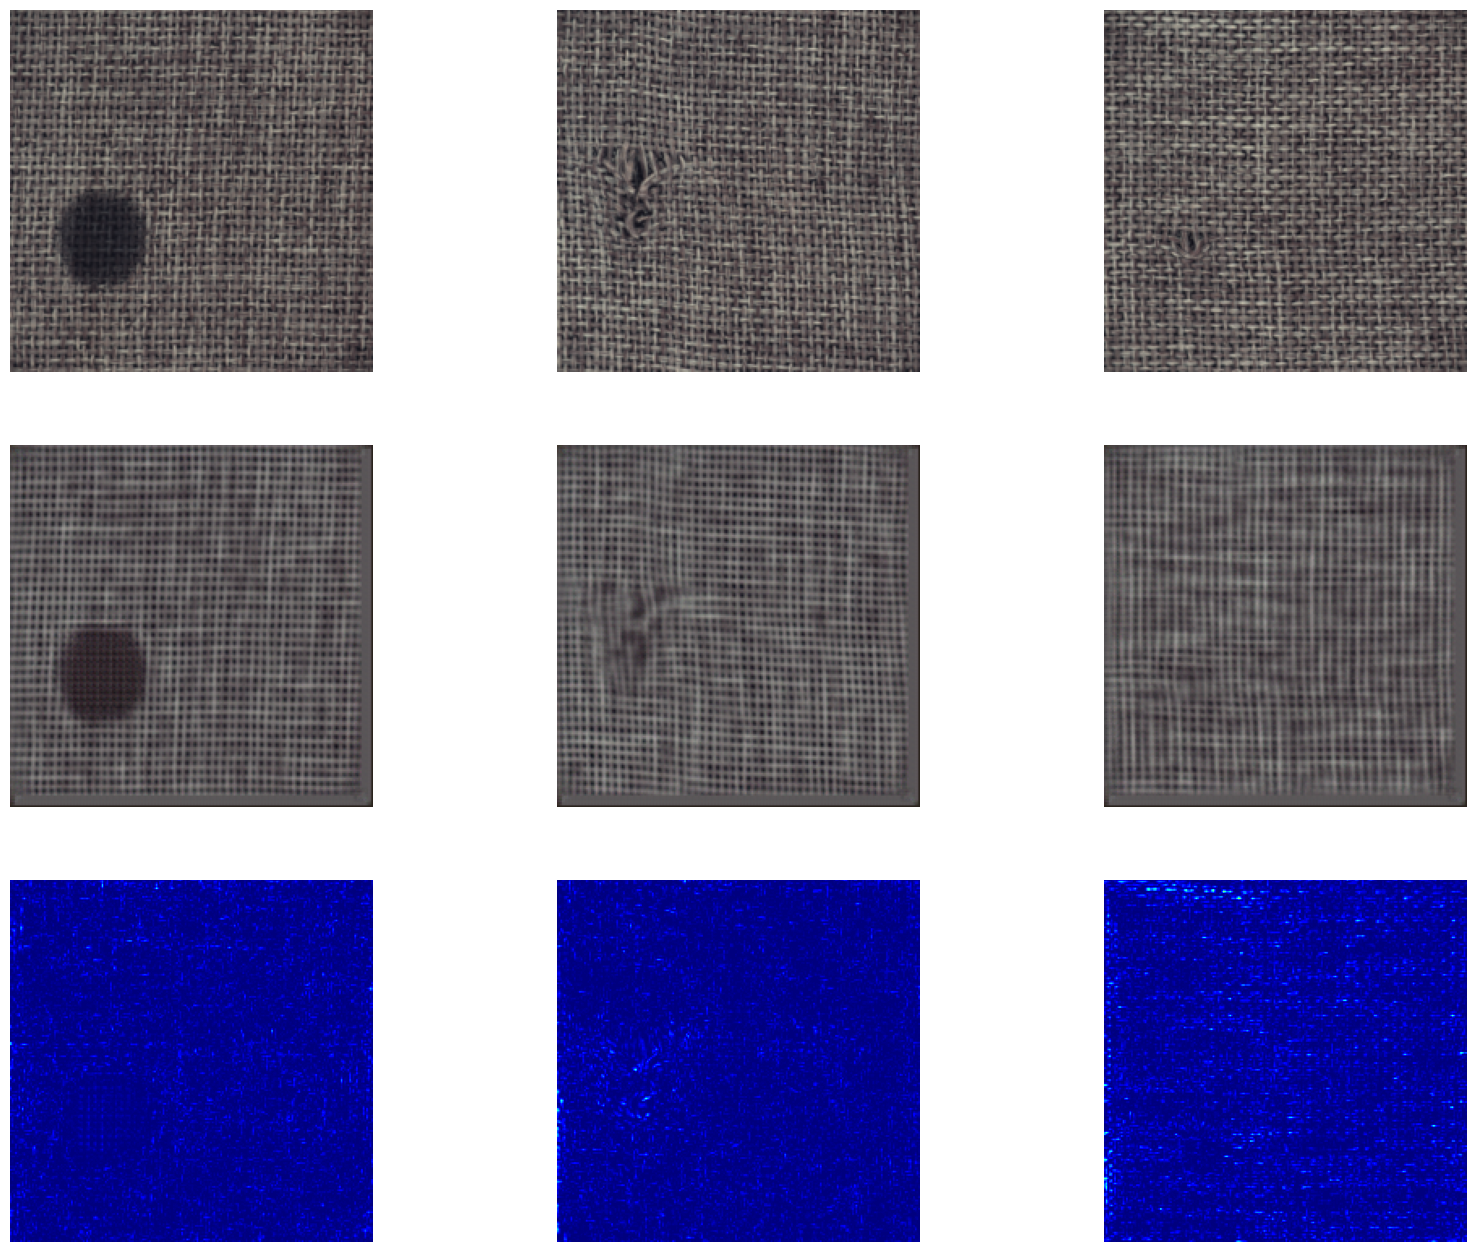

In [8]:
test1 = trans(Image.open(r"Detection/Carpet/carpet/test/color/000.png"))
test2 = trans(Image.open(r"Detection/Carpet/carpet/test/cut/000.png"))
test3 = trans(Image.open(r"Detection/Carpet/carpet/test/hole/000.png"))

data = torch.stack([test1, test2, test3])

with torch.no_grad():
    data = data.to(device)
    recon = model(data)
recon_error = ((data- recon)**2).mean(axis =1)
plt.figure(dpi = 250)
fig, ax = plt.subplots(3,3, figsize=(20, 16))

for i in range(3):
    ax[0, i].imshow(data[i].cpu().numpy().transpose((1,2,0)))
    ax[1, i].imshow(recon[i].cpu().numpy().transpose((1,2,0)))
    ax[2, i].imshow(recon_error[i][0:-10, 0:-10].cpu().numpy(), cmap = 'jet', vmax= torch.max(recon_error[i]))
    ax[0, i].axis('OFF')
    ax[1, i].axis('OFF')
    ax[2, i].axis('OFF')
plt.show()
    
    


# Obtain the fault detection accuracy

In [10]:
Recon_error = []
with torch.no_grad():
    for data, _ in tr_dl:
        data = data.to(device)
        recon = model(data)
        data_recon_squared_mean = ((data- recon)**2).mean(axis = (1))[:, 0:-10,0 :-10].mean(axis = (1,2))
        Recon_error.append(data_recon_squared_mean)
    
Recon_error = torch.cat(Recon_error).cpu().numpy()       

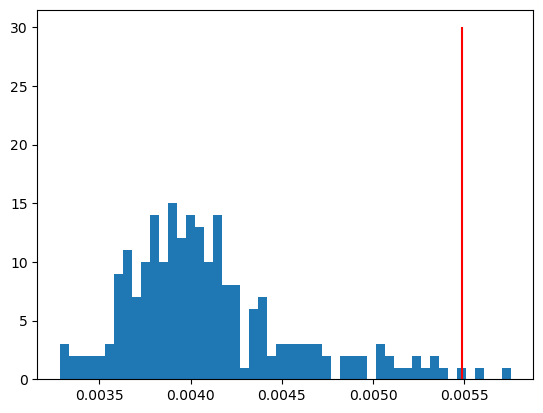

In [15]:
best_threshold = np.mean(Recon_error)+3 * np.std(Recon_error)
plt.hist(Recon_error, bins= 50)
plt.vlines(x = best_threshold, ymin=0, ymax=30, color = "r")
plt.show()

In [38]:
# test

y_true=[]
y_pred=[]
y_score=[]

model.eval()
with torch.no_grad():
    test_path = Path("Detection/Carpet/carpet/test")
    for path in test_path.glob("*/*.png"):
        fault_type = path.parts[-2]
        test_img = trans(Image.open(path)).to(device).unsqueeze(0)
        recon_img = model(test_img)
        y_score_image = ((test_img - recon_img)**2).mean(axis=(1))[:,0:-10, 0:-10].mean()
        y_pred_img = 1*(y_score_image >= best_threshold)
        y_true_img = 0 if fault_type == "good" else 1

        y_true.append(y_true_img)
        y_pred.append(y_pred_img.cpu())
        y_score.append(y_score_image.cpu())
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)
    

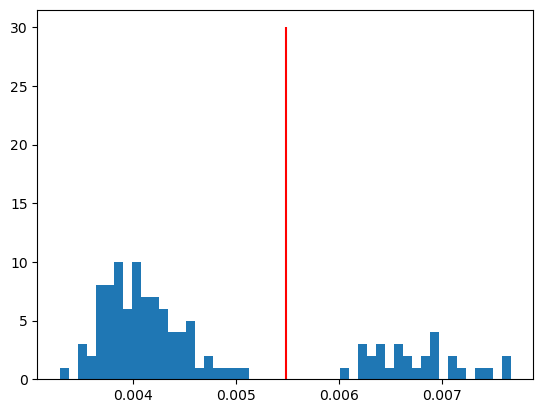

In [39]:
plt.hist(y_score, bins = 50)
plt.vlines(x = best_threshold, ymin = 0, ymax = 30, color ="r")
plt.show()

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score
import seaborn as sns

AUC = roc_auc_score(y_true, y_score)
print(f"AUC- ROC Score {AUC}")

AUC- ROC Score 0.42134831460674155


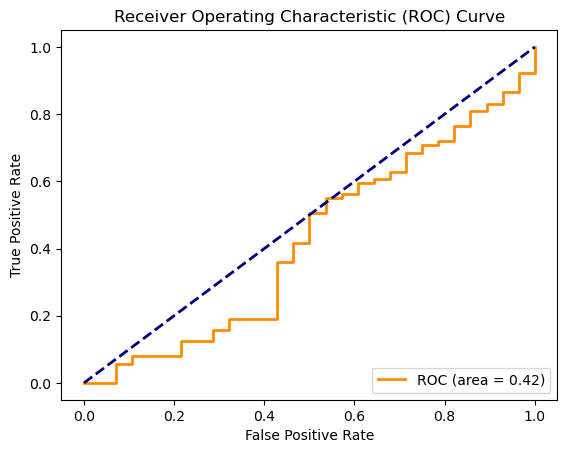

In [43]:
fpr, tpr, thresholds = roc_curve(y_true, y_score)
plt.figure()
plt.plot(fpr, tpr, color = "darkorange", lw = 2, label = "ROC (area = %0.2f)"%AUC)
plt.plot([0,1], [0,1], color = "navy", lw =2, linestyle = "--")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()